# Problema 2:
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de 20 x 10 pulgadas y su espesor de una pulgada. El radio del agujero
central es también de 1 pulgada. Tome E = 30 x 106
 psi y n = 0.30.
Analice el problema con número creciente de elementos y estudie su convergencia

Aprovechando la simetría del ejercicio, se simula un cuarto de la pieza:

                                           l2
                                  p4------------------p3
                                   l                   l
                               l1  l           S       l
            Empotrado              l                   l    l3     Traccionado
                                   p5-----\            l
                                   l      l            l
                                   p1----p6------------p2 
                                               l4


buenismimo el dibujito ascii!

Bueno a ver, había varias cosas. por otro lado me costó terminar de encontrar todos los errores y terminé haciendo algo de barullo pero vamos a ver las cosas mas importantes.

In [1]:
import gmsh
import numpy as np
import copy

GL = 2     # Grados de libertad
E = 30e6   # psi Modulo de elasticidad
v = 0.3    # Módulo de Poisson
T = 1000   # Tensión de tracción

In [2]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,10))
plt.rc('axes', labelsize=24 )
plt.rc('xtick', labelsize=24 )
plt.rc('ytick', labelsize=24 )
plt.rc('legend', fontsize=20)

In [3]:
gmsh.initialize()
gmsh.model.add('ej2')

Definición de puntos

In [4]:
# Sección rectangular

lc = 1                                       # Refinamiento del mallado
H = 5                                        # Alto en pulgadas
L = 10                                       # Largo en pulgadas
Es = 1                                       # Espesor en pulgadas
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc) 
p3 = gmsh.model.geo.addPoint(L, H, 0, lc) 
p4 = gmsh.model.geo.addPoint(0, H, 0, lc) 

# Sección circular central (Agujero)

r = 1                                        # Radio en pulgadas
la = 0.1              # Refinamiento del mallado cerca del círculo
p5 = gmsh.model.geo.addPoint(0, r, 0, la)
p6 = gmsh.model.geo.addPoint(r, 0, 0, la)

Definición de lineas entre los puntos y las uno para formar las curvas

In [5]:
# Sección llena

l1 = gmsh.model.geo.addLine(p5, p4)
l2 = gmsh.model.geo.addLine(p4, p3)
l3 = gmsh.model.geo.addLine(p3, p2)
l4 = gmsh.model.geo.addLine(p2, p6)

Rect = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

# Semicírculo en una esquina

semi = gmsh.model.geo.addCircleArc(p5,p1,p6)

Circ = gmsh.model.geo.addCurveLoop([semi])

* Determino la superficie rectancular descontando el círculo
* Sincronizo los elementos geométricos

In [6]:
S = gmsh.model.geo.addPlaneSurface([Rect, Circ])

gmsh.model.geo.synchronize()

Condiciones de contorno: defino los grupos físicos

In [7]:
# Empotramientos (cortes de simetría)

EmpX = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,EmpX, "EmpX")

EmpY = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1,EmpY, "EmpY")

In [8]:
# Contornos traccionados

Trac = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1,Trac,'Trac')

In [9]:
# Superficie 

Sup = gmsh.model.addPhysicalGroup(2,[S])
gmsh.model.setPhysicalName(2, Sup, 'Sup')

In [10]:
# Eliminación del punto 1 auxiliar

trash = gmsh.model.addPhysicalGroup(0, [p1])
gmsh.model.setPhysicalName(0,trash, "trash")

Generación del mallado indicando su dimensión

In [11]:
gmsh.model.geo.synchronize()

In [12]:
gmsh.model.mesh.generate(2)   # hay que correrlo dos veces, sino no funciona, pq?

Extracción de datos de mallado generado

<div style='background-color:#0000FF'> Hasta acá estaba todo bien. </div>

In [13]:
# Nodos

nodos = gmsh.model.mesh.get_nodes()      # Información de los nodos del mallado
#nodos[1].shape
N = nodos[0].shape[0]                    # Número de nodos
MN = nodos[1].reshape(N , 3)             # Matriz de nodos

# Elementos

e_tags, e = gmsh.model.mesh.get_elements_by_type(2)  # Información de los elementos tipo 2 (triangulares)
MC = e.reshape([e_tags.shape[0],3])      # Matriz de conectividad

# Traccionados

ent_trac = gmsh.model.getEntitiesForPhysicalGroup(1, Trac)      # Entidad de elementos traccionados
t1, t2, long_trac = gmsh.model.mesh.getElements(1, ent_trac[0]) 
Long_trac = long_trac[0].reshape(t2[0].shape[0],2)  # Nodos de cada elemento de la entidad

Calculo las fuerzas

<div style='background-color:#0000FF'> Esto esta perfecto como se ve en el dibujo de abajo. </div>

In [14]:
F = np.zeros((2*N, 1))

for i, line in enumerate(Long_trac):
    n1 = int(line[0]-1)
    n2 = int(line[1]-1)
    long = np.abs(MN[n1,1]-MN[n2,1])
    Floc = (T * long * Es)/2 * np.array([[1],[1]])
    F[ np.array([2*n1, 2*n2]) ] += Floc


In [15]:
Fx = F[::2]; Fy = F[1::2]

In [16]:
NodosTriangulos = gmsh.model.mesh.get_nodes_for_physical_group(2, Sup)

<div style='background-color:#0000FF'>Acá te diría de definit también N_trash</div>

In [17]:
Nx_emp = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpX)
Ny_emp = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpY)
#MDF_COMMENT también podes sacar los que estan en trash
N_trash = gmsh.model.mesh.get_nodes_for_physical_group(0,trash)

(-1.0, 13.0)

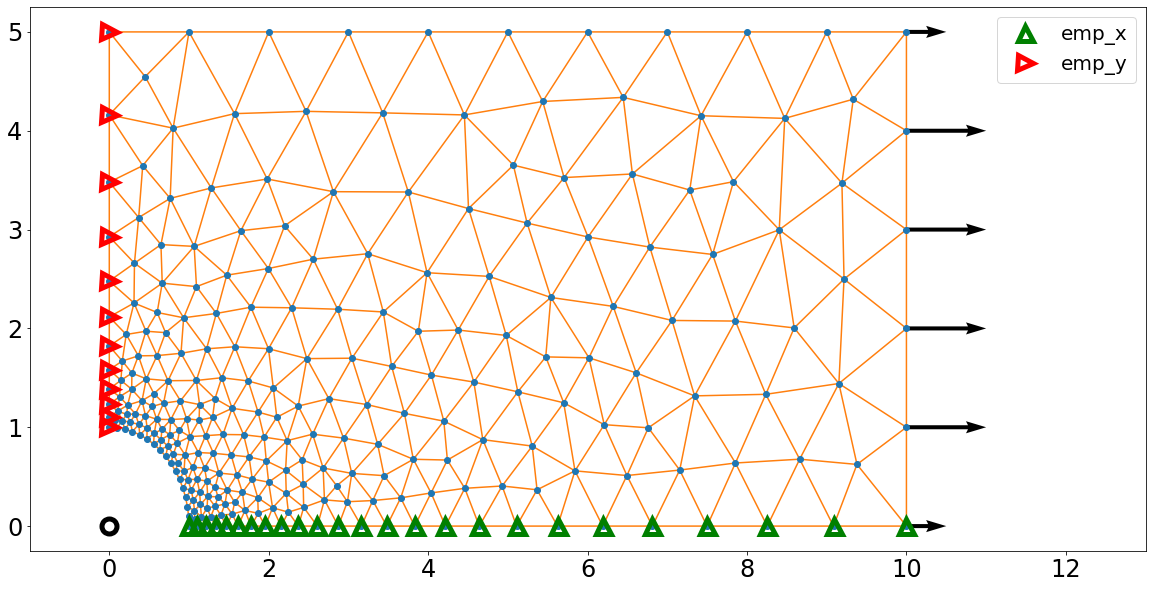

In [18]:
plt.plot(MN[NodosTriangulos[0]-1, 0], MN[NodosTriangulos[0]-1,1], 'o')
plt.triplot(MN[NodosTriangulos[0]-1, 0], MN[NodosTriangulos[0]-1, 1], MC-MC.min())
plt.quiver(MN[1:, 0], MN[1:, 1], Fx[1:], Fy[1:], scale=1000,units='x')

plt.plot(MN[Nx_emp[0]-1, 0], MN[Nx_emp[0]-1,1], '^', label='emp_x', markersize=15, markerfacecolor='none', markeredgecolor='g', markeredgewidth=5)
plt.plot(MN[Ny_emp[0]-1, 0], MN[Ny_emp[0]-1,1], '>', label='emp_y', markersize=15, markerfacecolor='none', markeredgecolor='r', markeredgewidth=5)
plt.plot(MN[N_trash[0]-1, 0], MN[N_trash[0]-1,1], 'o', markersize=15, markerfacecolor='none', markeredgecolor='k', markeredgewidth=5)
plt.legend()
plt.xlim([-1, L+3])

Saco datos del mallado

<div style='background-color:#0000FF'>acá el primer problema </div>
<div style='background-color:#990099'>tenías mal puestos los empotramientos: los del eje x no se pueden mover en y, y los del eje y no se pueden mover en x, De yapa, una forma de hacerlo sin los for,</div>

In [19]:
#s= []
#for n, nod in enumerate(Nx_emp[0]):
#    s.append(2*nod)
#    s.append(2*nod+1)
#for n, nod in enumerate(Ny_emp[0]):
#    s.append(2*nod)
#    s.append(2*nod+1)

#s = np.array(s).astype(int)
s = np.hstack(
    [
        2*(Nx_emp[0]-1)+1,
        2*(Ny_emp[0]-1),
        2*(N_trash[0]-1),
        2*(N_trash[0]-1)+1,
    ]
)

In [20]:
s

array([  3,  11,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,
        81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,   6,
         8,  12,  14,  16,  18,  20,  22,  24,  26,  28,  30,   0,   1],
      dtype=uint64)

luego saco de r todo lo que puse en s:

In [21]:
r = np.delete( np.arange(2*N) , s )

In [22]:
import pdb

<div style='background-color:#0000FF'>acá el problema mas grande</div>
<div></div>
<div style='background-color:#990099'>Había algun problema con la forma de definir los B[alfa, beta, gamma], que no pude terminar de entender. lo reemplazo por una forma más directa de calcularlo,</div>
<div></div>
<div style='background-color:#990099'>Por otro lado tenías mal indexada la matriz local.</div>

In [23]:
el = len(MC)      # cantidad de elementos
K = np.zeros([N*GL, N*GL])
Esf= []
Bs=[]
#for a in range(el):
for el, etag in enumerate(e_tags): #range(el):
    B = np.zeros([3,6])
    c = []              #coordenadas de los nodos del elemento
#    for i in MC[a]:
#        aux=MN[int(i-1)].copy()  # este es el elemento
#        pdb.set_trace()
#        aux[2]=1
#        c.append(aux)
#        b=[0,0,0]
#        g=[0,0,0]
#    _x = MN[(MC[a]-1).astype(int), 0 ]
#    _y = MN[(MC[a]-1).astype(int), 1 ]
    _x = MN[(MC[el]-1).astype(int), 0 ]
    _y = MN[(MC[el]-1).astype(int), 1 ]
    c = np.hstack([np.ones_like(_x.reshape(-1,1)), _x.reshape(-1,1), _y.reshape(-1,1)])
    A = np.linalg.det(c)/2
    alpha = [_x[1]*_y[2] - _x[2]*_y[1], _x[0]*_y[2] - _x[2]*_y[0], _x[0]*_y[1] - _x[1]*_y[0]]
    beta = [_y[1] - _y[2], _y[2] - _y[0], _y[0] - _y[1]]
    gamma = [_x[2] - _x[1], _x[0] - _x[2], _x[1] - _x[0]]
    B = (1/(2*A))*np.array(
            [
                [beta[0], 0., beta[1], 0, beta[2], 0],
                [0., gamma[0], 0., gamma[1], 0., gamma[2]],
                [gamma[0], beta[0], gamma[1], beta[1], gamma[2], beta[2]]
                ]
            )

#    for d in range(3): 
#        b[d] = c[d-2][1]- c[d-1][1]
#        g[d] = c[d-1][0]- c[d-2][0]
#    for j in range(3):
#        B0=[[b[j],0],[0, g[j]], [g[j], b[j]]]
#        B[0][j*2]=b[j]
#        B[1][2*j+1]=g[j]
#        B[2][j*2]=g[j]
#        B[2][j*2+1]=b[j]
#    B = B/(2*A)   (c) Weht
    Bs.append(B)
    D = (E/(1-(v**2)))*np.array([[1,v,0],[v,1,0],[0,0,(1-v)/2]])
#    k = Es*abs(A)*np.dot(B.transpose(), np.dot(D,B) )
    k = Es*abs(A)*np.dot(B.transpose(), np.dot(D,B) )
    K0 = np.zeros([N*2, N*2])
    for i in range(3):
#        nx=int(MC[a][i]-1)
        nx=int(MC[el][i]-1)
        for j in range(3):
#            ny=int(MC[a][j]-1)
            ny=int(MC[el][j]-1)
#            K0[np.ix_([nx*2,nx*2+1], [ny*2,ny*2+1])]+=k[i*2:i*2+2, j*2:j*2+2]
            K0[np.ix_([nx*2,nx*2+1], [ny*2,ny*2+1])]+=k[np.ix_([i*2,i*2+1],[j*2,j*2+1])]
    K+=K0

<div style='background-color:#0000FF'>Problema con los resultados </div>
<div style='background-color:#990099'>No terminé de entender por qué pero la indexación de los resultados que está comentada estaba mal tambien. a demás alcanza con la linea 8, sin hacer un for</div>

In [24]:
d = np.zeros(N*GL)
f = np.zeros(N*GL)

dd = np.linalg.solve(K[np.ix_(r,r)], F[r])

#MDF_COMMENT for i in range(len(r)):
#MDF_COMMENT     d[r[i]]=dd[i]
d[r] = dd.ravel()

F_result=K.dot(d)
B=np.array(B)
D=np.array(D)

Los desplazamientos parece que dan bien ahora

In [25]:
Dx = d[::2]
Dy = d[1::2]
Fresultx = F_result[::2]
Fresulty = F_result[1::2]

(-1.0, 12.0)

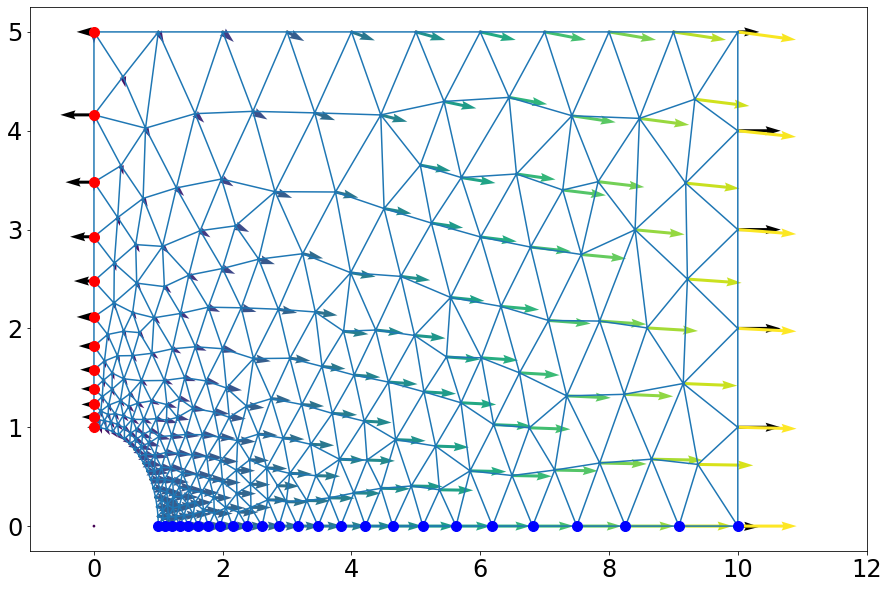

In [26]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.triplot(MN[1:,0], MN[1:,1],MC-MC.min())
plt.plot(MN[Nx_emp[0]-1,0], MN[Nx_emp[0]-1,1], 'ob', markersize=10)
plt.plot(MN[Ny_emp[0]-1,0], MN[Ny_emp[0]-1,1], 'or', markersize=10)
#ax.quiver(MN[1:,0], MN[1:,1], Fx[1:], Fy[1:], units='x',scale=1500)
ax.quiver(MN[1:,0], MN[1:,1], Fresultx[1:], Fresulty[1:], units='x',scale=1500)
ax.quiver(MN[:,0], MN[:,1], Dx, Dy, Dx,  scale=0.5e-2)
ax.set_xlim([-1,12])

<div style='background-color:#0000FF'>contador sobre e</div>
<div style='background-color:#990099'>acá estaba mal el contador del for, que mas arriba lo definis como la matriz de elementos. lo reemplacé por un enumerate sobre la matriz de conectividad.</div>

a demás cambié otras cosas en las idas y vueltas buscando lo que estaba mal de los esfuerzos. 

In [27]:
Esf = []

#for i in range(e):
for e, ele  in enumerate(MC):
#for e, etag in enumerate(e_tags):
#    j=np.array(e-1, dtype=int)*2
    ele = MC[e,:]
    j=(ele-1).astype(int)
    index = np.array(
        [2*j[0],2*j[0]+1,2*j[1],2*j[1]+1,2*j[2],2*j[2]+1], dtype=int
    )
#    index2=np.hstack([2*(ele-1), 2*(ele-1)+1])
#    print(f' element: {index}', f' index2: {index2}')
    Esf.append( np.dot( np.dot(D,Bs[e]), d[index] ) ) 
#    Esf.append( np.dot( np.dot(D,Bs[etag]), d[index] ) ) 
Esf=np.array(Esf)
    

In [28]:
Esf.shape

(484, 3)

In [29]:
T_max = (Esf[:,0]+Esf[:,1])/2 + np.sqrt(((Esf[:,0]+Esf[:,1])**2)/4 + Esf[:,2]**2)

(-1.0, 12.0)

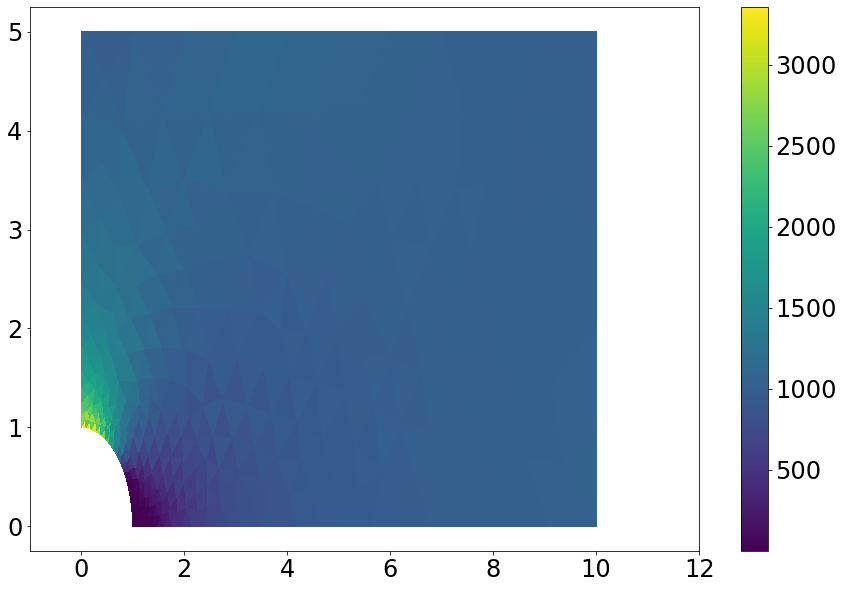

In [30]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
cmap = ax.tripcolor(MN[NodosTriangulos[0]-1,0],
                    MN[NodosTriangulos[0]-1,1],
                    MC-MC.min(), 
                    facecolors=T_max,
#                    edgecolor='k',
                    linewidth=1
                   )
#ax.plot(MN[Nx_emp[0]-1,0], MN[Nx_emp[0]-1,1], 'ob', markersize=10)
#ax.plot(MN[Ny_emp[0]-1,0], MN[Ny_emp[0]-1,1], 'or', markersize=10)
cbar = plt.colorbar(cmap)
ax.set_xlim([-1,12])